In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud,STOPWORDS
import spacy as sp
import string
import nltk
import re
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nlps = sp.load('en_core_web_sm')
plt.rc('figure',figsize=(17,11))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/natalio/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
p_data = pd.read_excel('/Users/natalio/Downloads/creepypastas.xlsx')
p_data.head(3)

story_name  average_rating  \
0  If You’re Armed and at the Glenmont Metro, Ple...            9.25   
1                                   A Shattered Life            9.13   
2      My Father Punished Me When I Talked to Ghosts            9.12   

                                                tags  \
0   drug trials, drugs, experimentation, experime...   
1   disease, entities, Matt Dymerski, monsters, p...   
2   abductions, blindness, child abuse, childhood...   

                                                body estimated_reading_time  \
0  If you’re armed and at the Glenmont metro, ple...             12 minutes   
1    I don’t know when you’re going to read this,...             14 minutes   
2  I’ve been blind since birth. As I grew up, eve...              8 minutes   

         publish_date                                         categories  
0  February 20, 2020    Drugs and Addictions, Madness, Paranoia, and ...  
1      July 22, 2020    Madness, Paranoia, and Mental Illness, Monste...  
2  December 10, 2019    Abductions and Kidnappings, Children and Chil...

In [ ]:
                                        DATA preprocessing

In [4]:
pre_processed = p_data.copy()

tag_df = p_data[['tags','average_rating']].copy()

all_tags = ' '.join(tag_df[tag_df.tags.notna()].tags)
all_tags = all_tags.replace('\n',' ').strip('\t')
all_tags = all_tags.strip().split(',')
tag_dict = {}
for tag in all_tags:
    t = tag.strip().lower()
    tag_dict[t] = tag_dict.get(t,0)+1        

    
    
all_categories = ' '.join(p_data[p_data.categories.notna()].categories)
all_categories = all_categories.replace('\n',' ').strip('\t')
all_categories = all_categories.strip().split(',')
categories_dict = {}
for category in all_categories:
    t = category.strip().lower()
    categories_dict[t] = categories_dict.get(t,0)+1        

    


def ert_preprocess(sir):
    if sir.find('<') == -1:
        if sir.find('minutes') != -1:
            return  np.int(sir.replace(' minutes',''))
        else:
            return  np.int(sir.replace(' minut',''))
    else:
        return 1
    
pre_processed.loc[pre_processed.estimated_reading_time.notna(),'estimated_reading_time'] = pre_processed.loc[pre_processed.estimated_reading_time.notna(),
                                                                                                             'estimated_reading_time'].apply(ert_preprocess)

#bad value
pre_processed.drop(index = 2511,inplace=True)


#covert to day column 
pre_processed.loc[pre_processed.publish_date.notna(),'publish_date'] = pd.to_datetime(pre_processed[pre_processed.publish_date.notna()].publish_date)
pre_processed['Year_Published'] = pre_processed.publish_date.apply(lambda x: x.year)
pre_processed['Month_Published'] = pre_processed.publish_date.apply(lambda x: x.month)
pre_processed['Day_Published'] = pre_processed.publish_date.apply(lambda x: x.dayofweek)

pre_processed.body =pre_processed.body.str.lower()
pre_processed.story_name =pre_processed.story_name.str.lower()

# Remove all the special characters
pre_processed.body = pre_processed.body.apply(lambda x:re.sub(r'\W', ' ', x))
pre_processed.story_name = pre_processed.story_name.apply(lambda x:re.sub(r'\W', ' ', x))
#remove all single characters
pre_processed.body = pre_processed.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
pre_processed.story_name = pre_processed.story_name.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
# Substituting multiple spaces with single space
pre_processed.body = pre_processed.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
pre_processed.story_name = pre_processed.story_name.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [5]:
sid = SIA()
pre_processed['sentiments']           = pre_processed['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
pre_processed['Positive Sentiment']   = pre_processed['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
pre_processed['Neutral Sentiment']    = pre_processed['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
pre_processed['Negative Sentiment']   = pre_processed['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

pre_processed.drop(columns=['sentiments'],inplace=True)

In [6]:
pre_processed.head(10)

story_name  average_rating  \
0  if you re armed and at the glenmont metro plea...            9.25   
1                                   a shattered life            9.13   
2        my father punished me when talked to ghosts            9.12   
3                          distorted warning signals            9.12   
4                                     he who wanders            9.12   
5                         the living history project            9.12   
6                     i found letter from my stalker            9.12   
7                                    don let them in            9.11   
8                 what happens when the stars go out            9.11   
9                          the seer of possibilities            9.11   

                                                tags  \
0   drug trials, drugs, experimentation, experime...   
1   disease, entities, Matt Dymerski, monsters, p...   
2   abductions, blindness, child abuse, childhood...   
3                              Ashley Rose Wellman\n   
4                                   Simon Simonian\n   
5   Christine O'Neill, deaths, diaries, dying, hi...   
6   messages, MinisterofOwls, mutilations, notes,...   
7   addictions, alcoholics, alcoholism, child abu...   
8   afterlife, deaths, feelspastas, Jesse Clark, ...   
9                                        Thomas O.\n   

                                                body estimated_reading_time  \
0  if you re armed and at the glenmont metro plea...                     12   
1   don know when you re going to read this but c...                     14   
2  i ve been blind since birth as grew up everyth...                      8   
3  when got the first one was literally seconds a...                      3   
4  i missed the scorching wind of andalusia how i...                     22   
5  one of my least favorite parts about being mid...                     10   
6  i found this note nailed onto tree on my front...                     12   
7  addiction took our mother slowly rocked her th...                     13   
8  the red lights are only making the pain worse ...                     21   
9  sometimes otherworldly beings find interesting...                     19   

  publish_date                                         categories  \
0   2020-02-20   Drugs and Addictions, Madness, Paranoia, and ...   
1   2020-07-22   Madness, Paranoia, and Mental Illness, Monste...   
2   2019-12-10   Abductions and Kidnappings, Children and Chil...   
3   2019-07-13   Beings and Entities, Deaths, Murders, and Dis...   
4   2017-01-24                               Beings and Entities    
5   2019-04-25   Artifacts and Objects, Deaths, Murders, and D...   
6   2019-01-06   Body Horror, Madness, Paranoia, and Mental Il...   
7   2019-05-28   Children and Childhood, Drugs and Addictions,...   
8   2020-06-25   Deaths, Murders, and Disappearances, Feelspas...   
9   2015-01-26                               Beings and Entities    

   Year_Published  Month_Published  Day_Published  Positive Sentiment  \
0            2020                2              3            0.066001   
1            2020                7              2            0.132001   
2            2019               12              1            0.101001   
3            2019                7              5            0.060001   
4            2017                1              1            0.079001   
5            2019                4              3            0.117001   
6            2019                1              6            0.093001   
7            2019                5              1            0.105001   
8            2020                6              3            0.132001   
9            2015                1              0            0.148001   

   Neutral Sentiment  Negative Sentiment  
0           0.832001            0.102001  
1           0.755001            0.113001  
2           0.772001            0.128001  
3           0.803001      

                                Exploratory Data Analysis
                                Numeric Feature Analysis

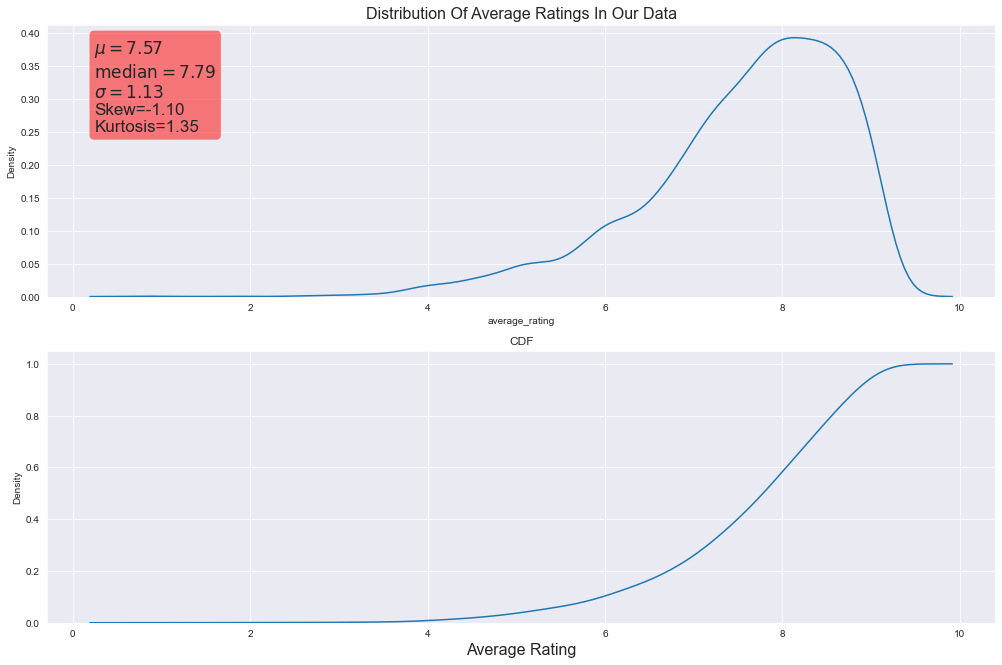

In [7]:
plt.subplot(2,1,1)
ax = sns.kdeplot(pre_processed.average_rating)

textstr = '\n'.join(
    
        (   r'$\mu=%.2f$' % (pre_processed.average_rating.mean(),)
          , r'$\mathrm{median}=%.2f$' % (pre_processed['average_rating'].median(),)
          , r'$\sigma=%.2f$' % (pre_processed['average_rating'].std(),)
          , r'Skew=%.2f' % (pre_processed['average_rating'].skew(),)
          , r'Kurtosis=%.2f' % (pre_processed['average_rating'].kurt(),)

        )
    
                  )

props = dict(boxstyle='round', facecolor='red', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)
ax.set_title('Distribution Of Average Ratings In Our Data',fontsize=16)



plt.subplot(2,1,2)
ax=sns.kdeplot(pre_processed.average_rating,cumulative=True)
ax.set_title('CDF')
ax.set_xlabel('Average Rating',fontsize=16)



plt.show()

Podemos observar que nuestra calificación promedio es de alrededor de 7.5, y las calificaciones se distribuyen de manera bastante normal con un ligero sesgo negativo.

Para un creepypasta aleatorio tomado de nuestro conjunto de datos, una probabilidad de 0.8 de que esté por encima de 6 estrellas de 10.

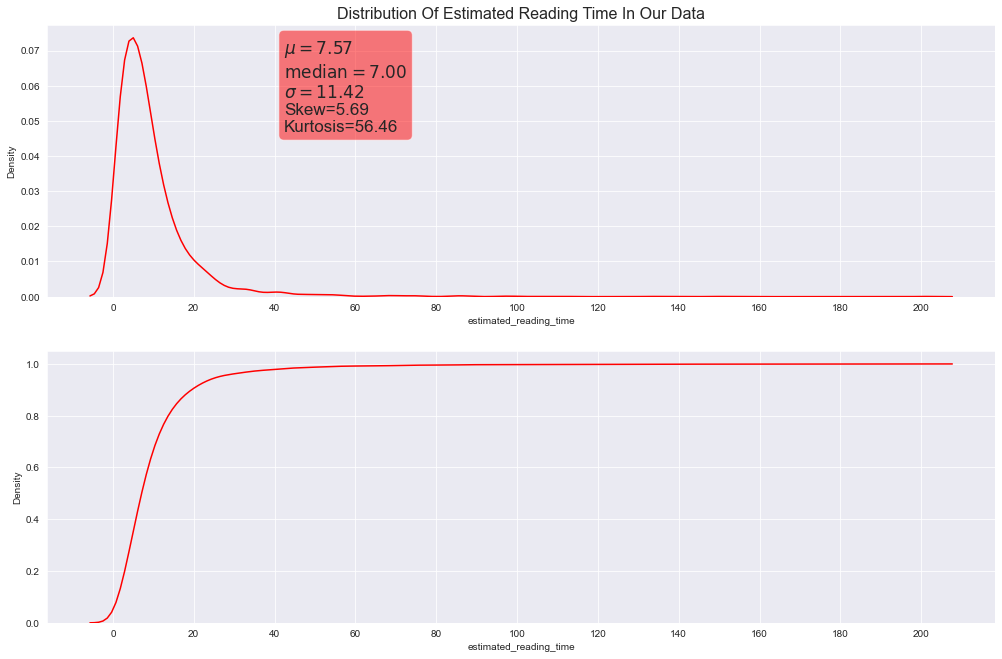

In [8]:
plt.subplot(2,1,1)
ax = sns.kdeplot(pre_processed.estimated_reading_time,color='red')

textstr = '\n'.join(
    
        (   r'$\mu=%.2f$' % (pre_processed.average_rating.mean(),)
          , r'$\mathrm{median}=%.2f$' % (pre_processed['estimated_reading_time'].median(),)
          , r'$\sigma=%.2f$' % (pre_processed['estimated_reading_time'].std(),)
          , r'Skew=%.2f' % (pre_processed['estimated_reading_time'].skew(),)
          , r'Kurtosis=%.2f' % (pre_processed['estimated_reading_time'].kurt(),)

        )
    
                  )

props = dict(boxstyle='round', facecolor='red', alpha=0.5)
ax.text(0.25, 0.95, textstr, transform=ax.transAxes, fontsize=17,
        verticalalignment='top', bbox=props)
ax.set_title('Distribution Of Estimated Reading Time In Our Data',fontsize=16)



ax.set_xticks(np.arange(0,220,20))
plt.subplot(2,1,2)
ax = sns.kdeplot(pre_processed.estimated_reading_time,color='red',cumulative=True)
ax.set_xticks(np.arange(0,220,20))
plt.show()

The estimated reading time has some outliers; as we can observe in the PDF and CDF above, on average, a creepypasta from our dataset takes about 8 minutes to read, but some longer ones can take up more than an hour.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.



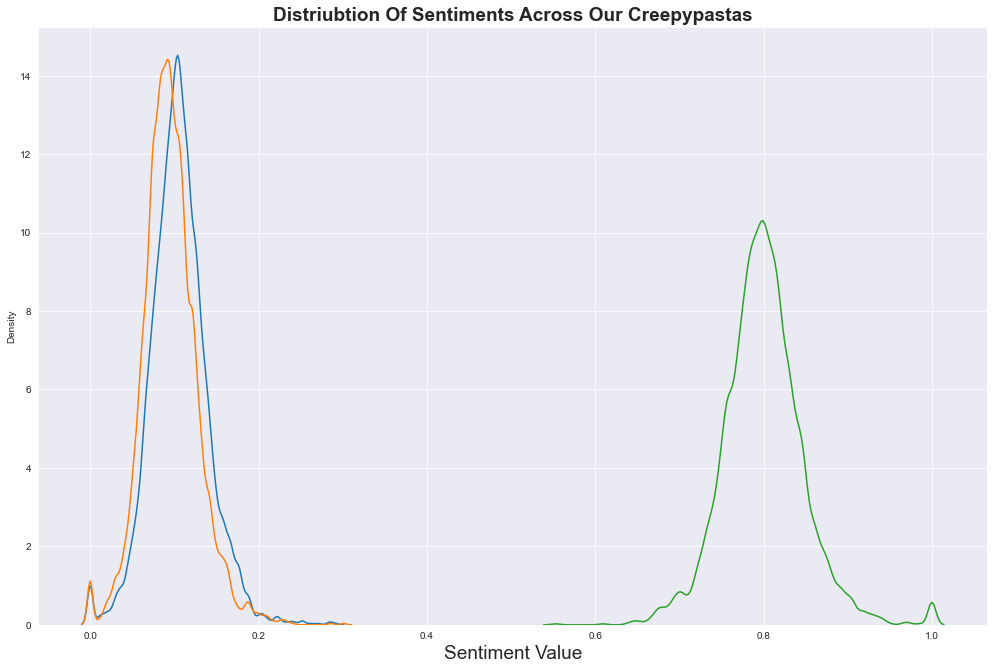

In [9]:
plt.title('Distriubtion Of Sentiments Across Our Creepypastas',fontsize=19,fontweight='bold')
sns.kdeplot(pre_processed['Negative Sentiment'],bw==0.1)
sns.kdeplot(pre_processed['Positive Sentiment'],bw_=0.1)
sns.kdeplot(pre_processed['Neutral Sentiment'],bw=0.1)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

The observation made from looking at the distributions of the sentiments is quite surprising; what would expect that the dominant sentiment in creepypastas would be negative, but we see that the positive and negative sentiments are almost centered around the same mean. The neutral sentiment is the dominant sentiment in all our stories.

In [10]:
fig = ex.scatter(pre_processed,x='average_rating',y='estimated_reading_time', trendline="ols",title='Is ERT Connected to The Average Rating?')
results = ex.get_trendline_results(fig)
fig.show()

In [11]:
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     225.7
Date:                Thu, 23 Jun 2022   Prob (F-statistic):           1.74e-49
Time:                        22:22:07   Log-Likelihood:                -13413.
No. Observations:                3509   AIC:                         2.683e+04
Df Residuals:                    3507   BIC:                         2.684e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0938      1.262     -7.208      0.000     -11.567      -6.620
x1             2.4777      0.165     15.023      0.000       2.154       2.801
==============================================================================
Omnibus:                     4056.038   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           552857.266
Skew:                           5.893   Prob(JB):                         0.00
Kurtosis:                      63.352   Cond. No.                         52.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is no significant correlation between the estimated reading time to the average rating given to a creepypasta.

Time Based Analysis

In [12]:
pre_processed.estimated_reading_time = pre_processed.estimated_reading_time.astype(np.int)
byear = pre_processed.groupby(by='Year_Published').mean()
byear = byear.reset_index()
byear

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=byear['Year_Published'], y=byear['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)



fig.add_trace(
    go.Scatter(x=byear['Year_Published'], y=byear['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)



fig['layout']['xaxis2']['title'] = 'Year Published'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

Our sentiments are less stable between 2008 and 2012, but I assume it is because of noise or outliers; I want to point your attention to the weak but amusing trend that can be observed starting from 2012.

Starting from 2012, the average yearly positive sentiment increases with each year ever so slightly as the negative sentiment decreases.

Does it mean our creepypastas slowly become more positive?

In [13]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Yearly Average Rating',  'Yearly Average Reading Time'))

fig.add_trace(
    go.Scatter(x=byear['Year_Published'], y=byear['average_rating'],name='Mean Rating'),
    row=1, col=1
)



fig.add_trace(
    go.Scatter(x=byear['Year_Published'], y=byear['estimated_reading_time'],name='Mean Reading Time'),
    row=2, col=1
)



fig['layout']['xaxis2']['title'] = 'Year Published'
fig.update_layout(height=700, width=900, title_text="Creepypasta Rating And ERT Yearly Averages")
fig.show()

Wow, that's really interesting! We can see that even though there is no clear trend in the average yearly scores except the two drops in 2012 and 2018 but at the same time, there is a clear and constant growing trend, with each year the average estimated reading time gets bigger, meaning that with each year the creepypastas become longer and longer!

In [14]:
bmonth = pre_processed.groupby(by='Month_Published').mean()
bmonth = bmonth.reset_index()

fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Monthly Average Rating',  'Monthly Average Reading Time'))

fig.add_trace(
    go.Scatter(x=bmonth['Month_Published'], y=bmonth['average_rating'],name='Mean Rating'),
    row=1, col=1
)



fig.add_trace(
    go.Scatter(x=bmonth['Month_Published'], y=bmonth['estimated_reading_time'],name='Mean Reading Time'),
    row=2, col=1
)



fig['layout']['xaxis2']['title'] = 'Month Published'
fig.update_layout(height=700, width=900, title_text="Creepypasta Rating And ERT Monthly Averages")
fig.show()

Interestingly on average, stories published in January are the longest, and there is a constant decrement in average rating and reading time as we approach August.

I suspect that our data has little to no stories published in August; hence we see such results.

Text Based Analysis

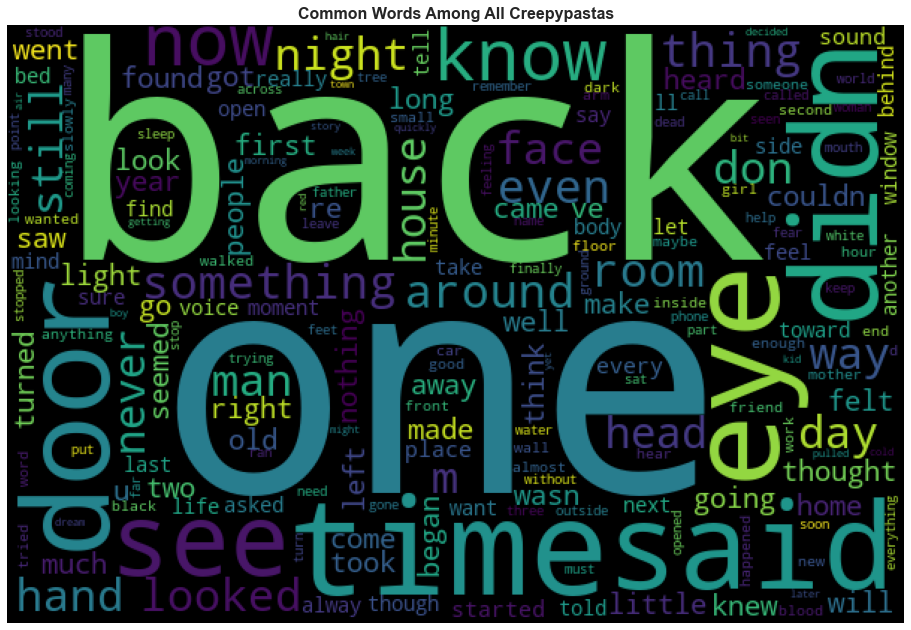

In [15]:
all_text = ' '.join(pre_processed.body)


pwc = WordCloud(width=600,height=400,collocations = False,stopwords=STOPWORDS).generate(all_text)
plt.title('Common Words Among All Creepypastas',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.show()

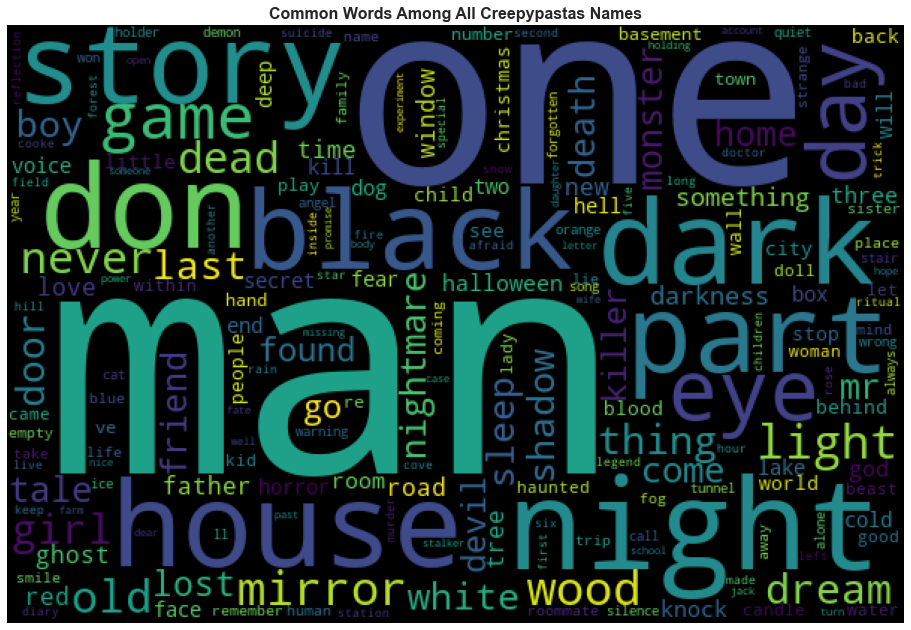

In [16]:
all_text = ' '.join(pre_processed.story_name)


pwc = WordCloud(width=600,height=400,collocations = False,stopwords=STOPWORDS).generate(all_text)
plt.title('Common Words Among All Creepypastas Names',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.show()

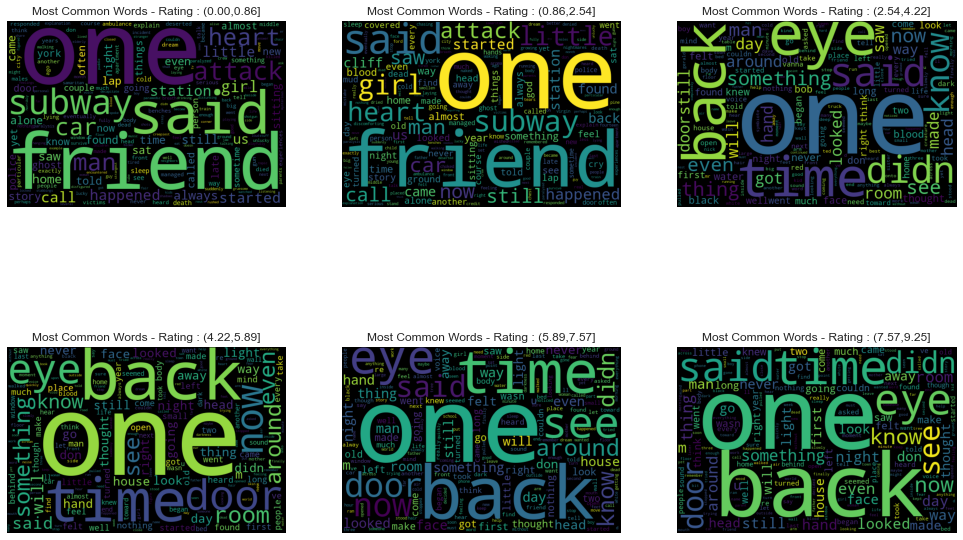

In [17]:
ticks = np.linspace(pre_processed.average_rating.min(),pre_processed.average_rating.max(),6)

s = 0
for index,p in enumerate(ticks):
    plt.subplot(2,3,index+1)
    t_text = pre_processed[pre_processed.average_rating.between(s,p)].body
    plt.title('Most Common Words - Rating : ({:.2f},{:.2f}]'.format(s,p))
    s=p
    pwc = WordCloud(width=600,height=400,collocations = False,stopwords=STOPWORDS).generate(' '.join(t_text))
    plt.imshow(pwc)
    plt.axis('off')

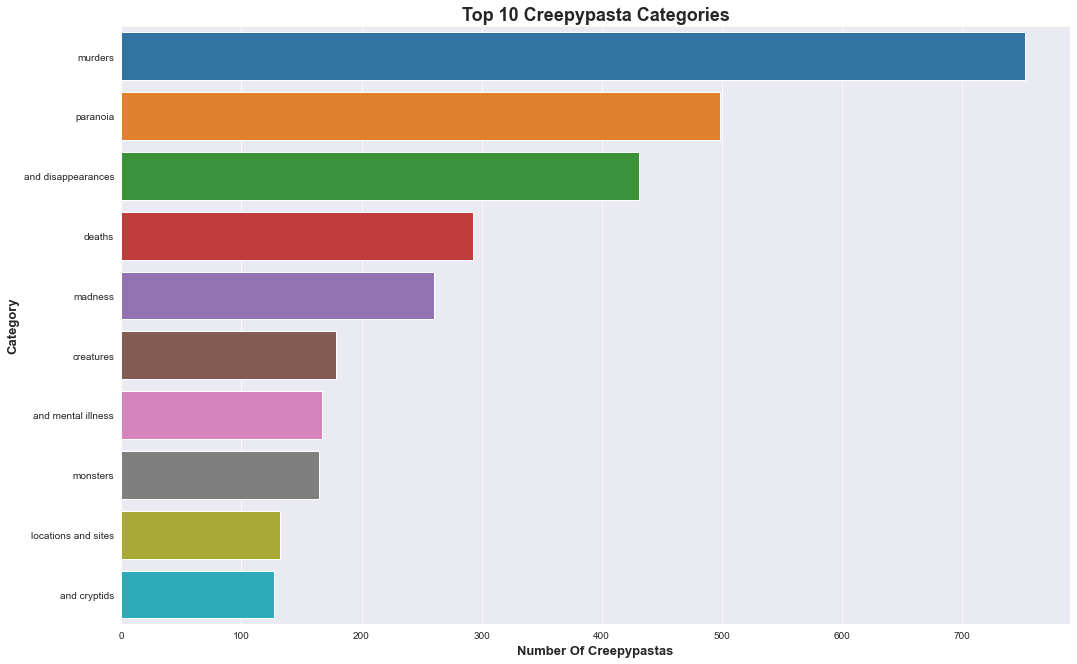

In [18]:
plt.title('Top 10 Creepypasta Categories',fontsize=18,fontweight='bold')
cat_df = pd.DataFrame({'Key':categories_dict.keys(),'Value':categories_dict.values()}).sort_values(by='Value',ascending=False)
sns.barplot(x=cat_df.iloc[:10,1],y=cat_df.iloc[:10,0])
plt.xlabel('Number Of Creepypastas',fontsize=13,fontweight='bold')
plt.ylabel('Category',fontsize=13,fontweight='bold')
plt.show()

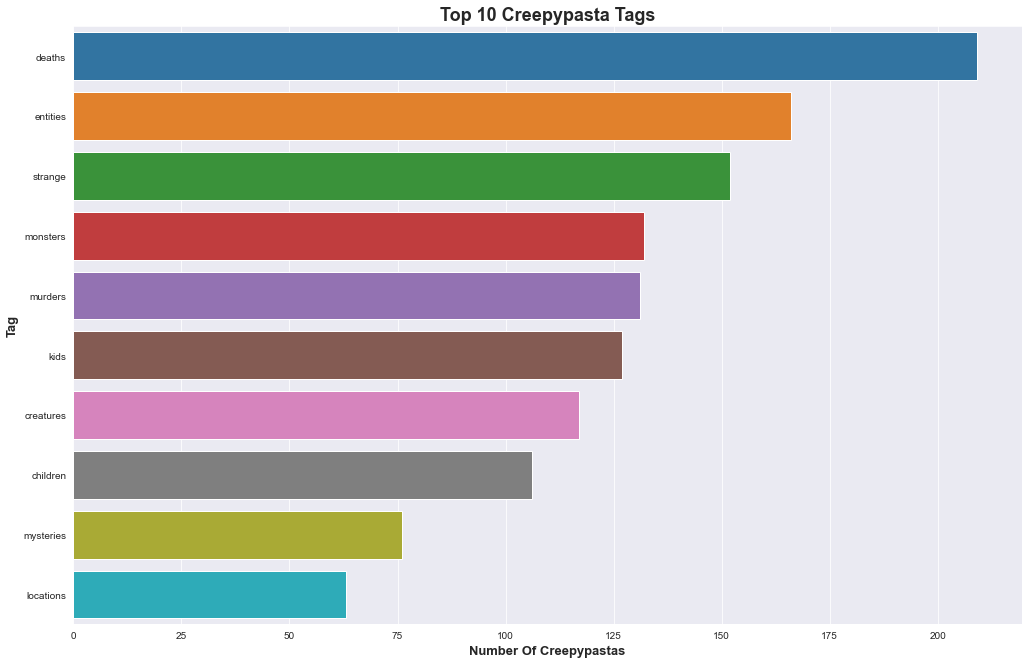

In [19]:
plt.title('Top 10 Creepypasta Tags',fontsize=18,fontweight='bold')
cat_df = pd.DataFrame({'Key':tag_dict.keys(),'Value':tag_dict.values()}).sort_values(by='Value',ascending=False)
sns.barplot(x=cat_df.iloc[:10,1],y=cat_df.iloc[:10,0])
plt.xlabel('Number Of Creepypastas',fontsize=13,fontweight='bold')
plt.ylabel('Tag',fontsize=13,fontweight='bold')
plt.show()